<B>TCC PUC MINAS - MAIO/2022</B><BR>
ANÁLISE DE PARCELAMENTO DE DÉBITOS INSCRITOS EM DÍVIDA ATIVA DA UNIÃO ATRAVÉS DE MACHINE LEARNING<BR>
FELIPE MARTINS<BR>

09 - MACHINE LEARNING
    
Tempo aproximado de processamento: 1h30

# 1. Preparo incial

**Importando as bibliotecas necessárias**

In [1]:
# Importando as bibliotecas necessárias

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
import pickle
from joblib import dump
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

**Carregando a base de dados**

In [2]:
df=pd.read_csv('07_dataset_final_com_dados_continuos.csv')  #nrows=10000

In [3]:
# EXCLUINDO COLUNA Unnamed
df = df.drop(columns=['Unnamed: 0', 'COD_TIPO_SIT_INSC', 'COD_SIT_INSC'])

**Primeiras 5 linhas**

In [4]:
df.head()

,TIPO_PESSOA,COD_RECEITA,INDICADOR_AJUIZADO,HA_OUTROS_DEBITOS,INSC_>1_ANO,VALOR_CONSOLIDADO,VALOR_FAIXA,COD_SIT_CADAST,COD_CNAE_PRINC,COD_NAT_JURID,COD_PORTE,ATIV_>10_ANOS,PARCELADO
0,1,0.009147,0,1,1,1.024026e-04,0.777778,-1.556471,0.275200,0.023340,0.041484,1,0
1,1,-0.066197,0,1,1,1.364299e-07,0.111111,0.490522,0.586070,-0.060573,0.041484,1,1
2,1,-0.066197,1,1,1,2.608829e-05,0.666667,-1.556471,0.198774,0.115958,-0.080524,1,0
3,1,0.009147,0,1,0,2.460639e-07,0.111111,0.490522,-0.059852,0.147429,0.125105,0,1
4,1,0.021237,0,1,1,2.765668e-07,0.111111,0.490522,0.295323,0.023340,0.041484,1,1


**Últimas 5 linhas**

In [5]:
df.tail()

,TIPO_PESSOA,COD_RECEITA,INDICADOR_AJUIZADO,HA_OUTROS_DEBITOS,INSC_>1_ANO,VALOR_CONSOLIDADO,VALOR_FAIXA,COD_SIT_CADAST,COD_CNAE_PRINC,COD_NAT_JURID,COD_PORTE,ATIV_>10_ANOS,PARCELADO
749642,1,0.009147,0,1,1,4.974330e-07,0.111111,0.490522,0.032369,0.023340,0.041484,0,0
749643,1,0.009147,0,1,1,4.684272e-07,0.111111,0.490522,0.000292,-0.060573,0.041484,1,0
749644,1,-0.629144,0,0,1,1.430652e-07,0.111111,0.490522,0.466813,-0.023395,-0.080524,1,0
749645,1,-0.066197,0,1,0,1.037075e-05,0.555556,0.490522,-0.057881,0.023340,-0.080524,1,0
749646,0,0.183730,0,1,0,6.845147e-07,0.222222,-0.110833,-0.110833,-0.110900,-0.110900,0,0


**Verificando tipo de dados**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749647 entries, 0 to 749646
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TIPO_PESSOA         749647 non-null  int64  
 1   COD_RECEITA         749647 non-null  float64
 2   INDICADOR_AJUIZADO  749647 non-null  int64  
 3   HA_OUTROS_DEBITOS   749647 non-null  int64  
 4   INSC_>1_ANO         749647 non-null  int64  
 5   VALOR_CONSOLIDADO   749647 non-null  float64
 6   VALOR_FAIXA         749647 non-null  float64
 7   COD_SIT_CADAST      749647 non-null  float64
 8   COD_CNAE_PRINC      749647 non-null  float64
 9   COD_NAT_JURID       749647 non-null  float64
 10  COD_PORTE           749647 non-null  float64
 11  ATIV_>10_ANOS       749647 non-null  int64  
 12  PARCELADO           749647 non-null  int64  
dtypes: float64(7), int64(6)
memory usage: 74.4 MB


**Verificando valores nulos**

In [7]:
df.isnull().sum()

TIPO_PESSOA           0
COD_RECEITA           0
INDICADOR_AJUIZADO    0
HA_OUTROS_DEBITOS     0
INSC_>1_ANO           0
VALOR_CONSOLIDADO     0
VALOR_FAIXA           0
COD_SIT_CADAST        0
COD_CNAE_PRINC        0
COD_NAT_JURID         0
COD_PORTE             0
ATIV_>10_ANOS         0
PARCELADO             0
dtype: int64

**Substituindo os valores nulos de todas as colunas por 0**

In [8]:
# SUBSTITUINDO DADOS NULOS / NAN POR ZERO PARA EVITAR ERROS NAS CONVERSÕES
df.fillna(value = 0, inplace = True)

**Verificando se ainda existem valores nulos no Dataset**

In [9]:
if df.isnull().sum().sort_values(ascending=False).any() != 0:
    print(f'Existem valores nulos no dataset? {True}')
else:
    print(f'Existem valores nulos no dataset? {False}')

Existem valores nulos no dataset? False


In [10]:
df.count()

TIPO_PESSOA           749647
COD_RECEITA           749647
INDICADOR_AJUIZADO    749647
HA_OUTROS_DEBITOS     749647
INSC_>1_ANO           749647
VALOR_CONSOLIDADO     749647
VALOR_FAIXA           749647
COD_SIT_CADAST        749647
COD_CNAE_PRINC        749647
COD_NAT_JURID         749647
COD_PORTE             749647
ATIV_>10_ANOS         749647
PARCELADO             749647
dtype: int64

# 2. Selecionando Features Importantes

**Separando a classe dos Dados**

In [11]:
# Separando os atributos e a classe do dataset em X e y:
X = df
X = df.drop('PARCELADO', axis=1) #removendo a variável target de X
y = df['PARCELADO'] # variável alvo/target

# Definindo uma SEED global
np.random.seed(7)

# Particionando em conjuntos de treino e teste mantendo a proporção de classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

In [12]:
#previsores = df.drop('PARCELADO',axis=1) ==> X
#classe = df['PARCELADO'] ==> y

**Criando classificador para visualizar as features mais importantes para o modelo**

In [13]:
%%time
# processamento demorado
clf_feature_import = RandomForestClassifier(n_estimators=100, random_state=12)
clf_feature_import = clf_feature_import.fit(X_train,y_train)

Wall time: 1min 10s


**Visualizando as features mais importantes**

In [14]:
feature_imp = pd.Series(clf_feature_import.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

VALOR_CONSOLIDADO     0.291073
COD_CNAE_PRINC        0.203444
COD_SIT_CADAST        0.145570
COD_RECEITA           0.134286
VALOR_FAIXA           0.058659
COD_NAT_JURID         0.051524
INSC_>1_ANO           0.034094
COD_PORTE             0.028431
INDICADOR_AJUIZADO    0.025139
ATIV_>10_ANOS         0.013400
HA_OUTROS_DEBITOS     0.011670
TIPO_PESSOA           0.002710
dtype: float64

**Visualizando graficamente as features mais importantes**

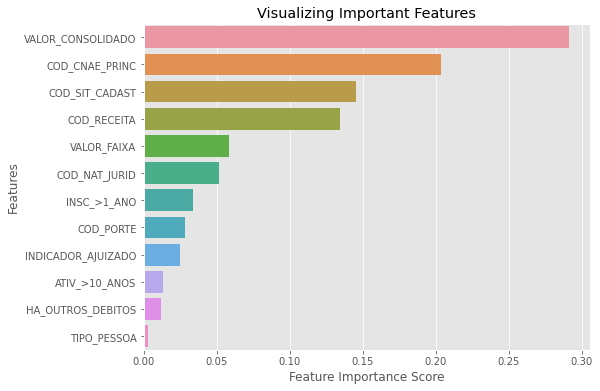

In [15]:
plt.figure(figsize=(8,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

**Selecionando as features de maior importância**

Aquelas acima de 1% de importância

In [16]:
features_selected = []
for feature,importance in feature_imp.iteritems():
# iteritems retorna um iterador que nos permiter iterar sobre a chave ou valor
    if importance > 0.02:
        print(f'{feature}: {round(importance * 100)}%')
        features_selected.append(feature)

VALOR_CONSOLIDADO: 29%
COD_CNAE_PRINC: 20%
COD_SIT_CADAST: 15%
COD_RECEITA: 13%
VALOR_FAIXA: 6%
COD_NAT_JURID: 5%
INSC_>1_ANO: 3%
COD_PORTE: 3%
INDICADOR_AJUIZADO: 3%


# 3. Treinando Modelos de Machine Learning

**Redividindo o dataset, desta vez apenas as features selecionadas**

In [17]:
# train_test_split já realizado no tópico anterior
X = df[features_selected]  # Atualizando X apenas para features selecionadas
y = df['PARCELADO']  # y permanece o mesmo


**Testando diversos algoritmos candidatos de Machine Learning**

In [84]:
%%time

print('TESTANDO ALGORITMOS COM BALANCEAMENTO PARAMETRIZADO')
print('MODELO:', 'ACCURACY', 'PRECISIO', 'RECALL  ', 'F1      ', 'MCC     ', 'ROC_AUC ',  'MEDIA GERAL')

clf_choose_model = []
clf_choose_model.append(('LRe', LogisticRegression(class_weight='balanced'))),
clf_choose_model.append(('Gau', GaussianNB())),
clf_choose_model.append(('DTr', DecisionTreeClassifier(class_weight='balanced'))),
clf_choose_model.append(('RFo', RandomForestClassifier(class_weight='balanced'))),
clf_choose_model.append(('KNN', KNeighborsClassifier())),
clf_choose_model.append(('XGB', XGBClassifier(scale_pos_weight=3.3)))

resultado_accuracy = []
resultado_precision = []
resultado_recall = []
resultado_f1 = []
resultado_mcc = []
resultado_roc_auc = []

resultado_geral = []
nomes = []

# Percorrendo cada um dos modelos, treinando-o e avaliando-o
for nome, modelo in clf_choose_model:
    modelo = modelo.fit(X_train,y_train)
    y_pred_choose_model = modelo.predict(X_test)
    ttsplit_result_accuracy = accuracy_score(y_test, y_pred_choose_model)
    ttsplit_result_precision = precision_score(y_test, y_pred_choose_model)
    ttsplit_result_recall = recall_score(y_test, y_pred_choose_model)
    ttsplit_result_f1 = f1_score(y_test, y_pred_choose_model)
    ttsplit_result_mcc = matthews_corrcoef(y_test, y_pred_choose_model)
    ttsplit_result_roc_auc = roc_auc_score(y_test, y_pred_choose_model)
    
    ttsplit_result_geral = (ttsplit_result_accuracy + ttsplit_result_precision + ttsplit_result_recall + ttsplit_result_f1 + ttsplit_result_mcc + ttsplit_result_roc_auc)/6
    
    resultado_accuracy.append(ttsplit_result_accuracy)
    resultado_precision.append(ttsplit_result_precision)
    resultado_recall.append(ttsplit_result_recall)
    resultado_f1.append(ttsplit_result_f1)
    resultado_mcc.append(ttsplit_result_mcc)
    resultado_roc_auc.append(ttsplit_result_roc_auc)
    
    resultado_geral.append(ttsplit_result_geral)
    nomes.append(nome)
    
# retornando a média das validações, bem como seu desvio padrão
    texto = "%s   : %f %f %f %f %f %f %f" % (nome, ttsplit_result_accuracy.mean(), ttsplit_result_precision.mean(), ttsplit_result_recall.mean(), ttsplit_result_f1.mean(),  ttsplit_result_mcc.mean(),  ttsplit_result_roc_auc.mean(), ttsplit_result_geral.mean())
    print(texto)

TESTANDO ALGORITMOS COM BALANCEAMENTO PARAMETRIZADO
MODELO: ACCURACY PRECISIO RECALL   F1       MCC      ROC_AUC  MEDIA GERAL
LRe   : 0.596118 0.336733 0.777311 0.469903 0.269333 0.659608 0.518168
Gau   : 0.549030 0.316148 0.823882 0.456951 0.249824 0.645338 0.506862
DTr   : 0.652478 0.347128 0.577937 0.433738 0.218830 0.626359 0.476078
RFo   : 0.666951 0.364226 0.598471 0.452850 0.248201 0.642956 0.495609
KNN   : 0.748869 0.426418 0.262164 0.324700 0.189186 0.578327 0.421611
XGB   : 0.633949 0.359562 0.754634 0.487055 0.296963 0.676237 0.534733
Wall time: 3min 15s


# 4. Fazendo Tuning do Modelo

**MODELO ESCOLHIDO: XGBoost / SCORE ALVO: F1**<BR>
Melhor modelo: XGBoost. Ajustaremos seus parâmetros com RandomizedSearchCV com vistas a obter o melhor f1_score possível.

In [20]:
%%time

# Definindo um dicionário que recebe as listas de parâmetros e valores
# Para visualizar todos os parâmetros, acesse (https://xgboost.readthedocs.io/en/stable/parameter.html)

parametros_grid = {'objective':['reg:squarederror', 'reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge'],
                   'booster':['gbtreee', 'dart'],
                   'scale_pos_weight':[1, 2, 3.3],
                   'learning_rate':[0.1, 0.3, 0.5],
                   'min_split_loss':[0, 0.1, 0.3, 0.5],
                   'max_depth':[4, 6, 8],
                   'min_child_weight':[1, 2],
                   'max_delta_step':[0,5,10]
                   }
                      
# Criando o modelo
clf_grid = XGBClassifier()

# Definindo K
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state=12)

# Testando diferentes combinações com os parâmetros
grid = RandomizedSearchCV(estimator=clf_grid, param_distributions=parametros_grid, cv=kfold, scoring='f1')
grid.fit(X, y)

# Print do resultado
print("Grid scores on development set:")
means = grid.cv_results_['mean_test_score'].round(5)
stds = grid.cv_results_['std_test_score'].round(5)

for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print(f'mean:{mean},std:{std},params:{params}')
print()
print(f'Melhor parâmetro:{grid.best_params_}, Score:{grid.best_score_}')

[06:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1205: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1205: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:54:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1205: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1

C:\Users\62914855320\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\62914855320\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\62914855320\Anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Users\62914855320\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1400, in fit
    self._Booster = train(
  File "C:\Users\62914855320\Anaconda3\lib\site-packages\

Grid scores on development set:
mean:0.2942,std:0.00118,params:{'scale_pos_weight': 2, 'objective': 'binary:logitraw', 'min_split_loss': 0.5, 'min_child_weight': 1, 'max_depth': 8, 'max_delta_step': 0, 'learning_rate': 0.1, 'booster': 'dart'}
mean:0.26034,std:0.00125,params:{'scale_pos_weight': 1, 'objective': 'reg:logistic', 'min_split_loss': 0.1, 'min_child_weight': 2, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.5, 'booster': 'dart'}
mean:nan,std:nan,params:{'scale_pos_weight': 1, 'objective': 'reg:logistic', 'min_split_loss': 0, 'min_child_weight': 1, 'max_depth': 8, 'max_delta_step': 5, 'learning_rate': 0.5, 'booster': 'gbtreee'}
mean:0.2544,std:0.00302,params:{'scale_pos_weight': 2, 'objective': 'binary:hinge', 'min_split_loss': 0.3, 'min_child_weight': 1, 'max_depth': 4, 'max_delta_step': 5, 'learning_rate': 0.1, 'booster': 'dart'}
mean:0.43899,std:0.00184,params:{'scale_pos_weight': 3.3, 'objective': 'binary:logitraw', 'min_split_loss': 0.5, 'min_child_weight': 1, 'm

# 5. Preparando a Versão Final do Modelo

**COM XGBoost**<BR>
Informar parâmetros indicados no RandomizeSearchCV

In [21]:
%%time

# Aplicando algoritmo com os melhores hiperparâmetros

# Separando os atributos e a classe do dataset em X e y:
X = df[features_selected]  # Reatualizando X apenas para selecionados
y = df['PARCELADO']  # y permanece o mesmo

# Instanciando o algoritmo classificador escolhido (XGBoost)
# Melhores parâmetros f1:{'scale_pos_weight': 3.3, 'objective': 'reg:logistic', 'min_split_loss': 0.5, 'min_child_weight': 1, 'max_depth': 8, 'max_delta_step': 10, 'learning_rate': 0.1, 'booster': 'dart'}, Score:0.48477567696982043
clf =  XGBClassifier(scale_pos_weight=3.3, objective='reg:logistic', min_split_loss=0.5, min_child_weight=1, max_depth=8, max_delta_step=10, learning_rate=0.1, booster='dart')

# Treinando o algoritmo classificador
clf = clf.fit(X, y)

# Realizando a predição do algoritmo utilizando-se de cross-validation
y_pred = cross_val_predict(clf, X, y, cv=5)

Wall time: 10min 39s


In [22]:
# Métricas de avaliação das predições

print('Acurácia:',accuracy_score(y, y_pred))
print('Precision score:',precision_score(y, y_pred))
print('Recall score:',recall_score(y, y_pred))
print('F1 score:',f1_score(y, y_pred))
print('MCC score:',matthews_corrcoef(y, y_pred))
print('ROCAUC score:',roc_auc_score(y, y_pred))

Acurácia: 0.6289213456466843
Precision score: 0.3563565688900503
Recall score: 0.7583150870607862
F1 score: 0.48486127931911865
MCC score: 0.29352794437581625
ROCAUC score: 0.6742612594169738


In [23]:
# Matriz de Confusão

print (pd.crosstab(y, y_pred, rownames = ['Real'], colnames = ['          Predito'], margins = True))

          Predito       0       1     All
Real                                     
0                  340555  236454  577009
1                   41724  130914  172638
All                382279  367368  749647


In [24]:
# Relatório de Classificação
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.59      0.71    577009
           1       0.36      0.76      0.48    172638

    accuracy                           0.63    749647
   macro avg       0.62      0.67      0.60    749647
weighted avg       0.77      0.63      0.66    749647



# 6. Persistindo o Modelo em Disco

**Persistindo com Pickle**

In [25]:
#filename = 'model_final.sav'
pickle.dump(clf, open('modelo.sav', 'wb'))
pickle.load(open('modelo.sav', 'rb'))

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=10, max_depth=8, max_leaves=0, min_child_weight=1,
              min_split_loss=0.5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='reg:logistic', predictor='auto', random_state=0, ...)

**Persistindo com Joblib**

In [26]:
dump(clf,'modelo.pkl')

['modelo.pkl']

**Carregando o modelo**

In [27]:
from joblib import load
model=load('modelo.pkl')

# 7. Apresentação dos Resultados
Avalidação do modelo<br>

**Matriz de Confusão**

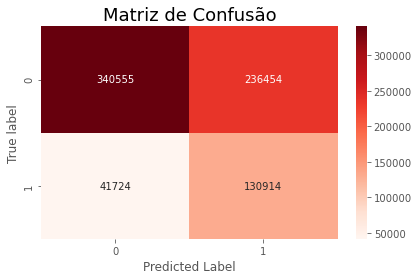

In [29]:
# Plotando a Matriz de confusão

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y, y_pred), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

**Curva ROC**

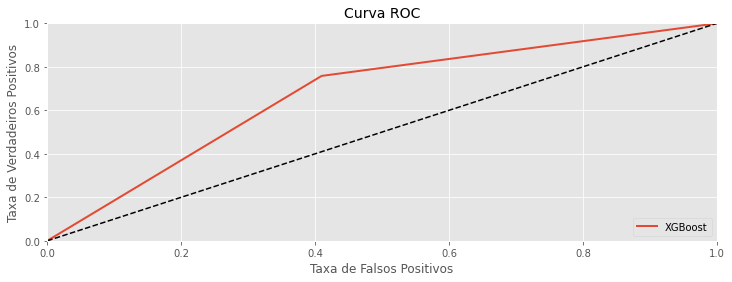

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, y_pred)
fig, ax = plt.subplots(figsize = (12,4))
plt.plot(fpr, tpr, linewidth=2, label = 'XGBoost')
plt.plot([0,1], [0,1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc = 'lower right')
plt.title('Curva ROC', fontsize = 14)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score
print('Área sob a curva ROC: {:.4f}'
      .format(roc_auc_score(y, y_pred)))

Área sob a curva ROC: 0.6743
